In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Load data

In [3]:
def transform(Y, R, t, s=1, transformation='rigid'):
    '''Transforms the given point set in a rigid manner'''
    
    if transformation == 'rigid':
        return np.transpose(s * np.dot(R, Y.T) + t) # np.tile(t.T, (Y.shape[0],1))
    #else if transformation == 'affine':
    #ToDo: Affine
        

In [6]:
bunny = pd.read_csv("bunny_source.txt", sep=" ", header=None, names=['X', 'Y', 'Z'])
print('Total number of NaNs in the data: ' + str(np.sum(bunny.isna().values)))

bunny = bunny.values
bunny = (bunny - np.mean(bunny, axis = 0)) /(np.max(bunny,axis=0) - np.min(bunny,axis=0))
theta= np.pi/6
R = np.array([[1, 0, 0],[0, np.cos(theta), -np.sin(theta)],[0, np.sin(theta), np.cos(theta)]])
bunny2 = transform(bunny, R, 0.4*np.ones((3,1)), 1)

Total number of NaNs in the data: 0


<IPython.core.display.Javascript object>


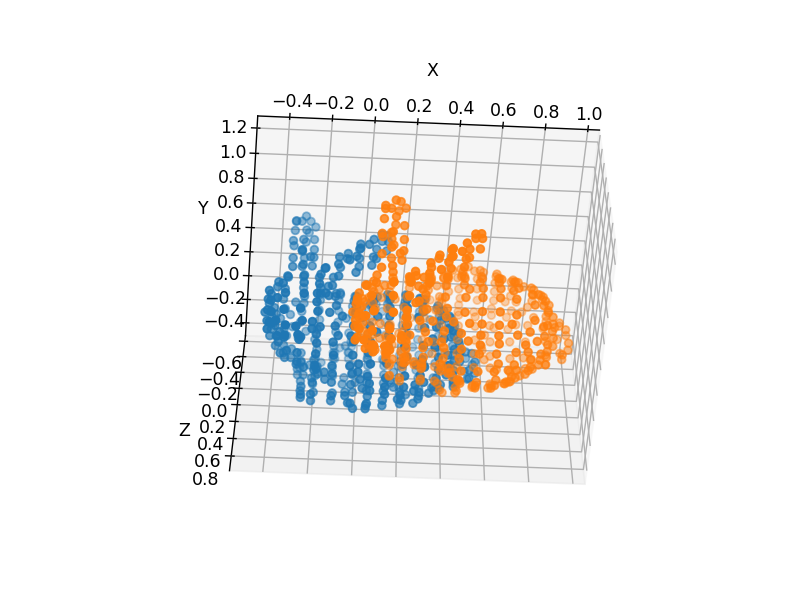

Text(0.5, 0, 'Z')

In [7]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bunny[:,0],bunny[:,1],bunny[:,2])
ax.scatter(bunny2[:,0],bunny2[:,1],bunny2[:,2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Rigid registration using [Coherent Point Drift](https://arxiv.org/pdf/0905.2635.pdf)

Wikipedia Link: https://en.wikipedia.org/wiki/Point_set_registration#Coherent_point_drift

## Initialization

Initialize $\sigma^2 = \frac{1}{DNM} \Sigma_{j=1}^N \Sigma_{i=1}^M ||x_j - y_i||^2$

For this, the matrix $E : e_{ij} = ||x_j - y_i||^2$ is defined as follows

In [8]:
def error2(X, Y):
    '''
    Given two 2D matrices of size (M x D) and (N x D), calculates the squared error matrix of size (N x M)
    Author:
        Zeeshan Khan Suri
    Licence:
        CC
    '''
    (M, D) = X.shape
    N = Y.shape[0]
    
    # Compute error matrix which will be used in expectation step
    err = X[:, np.newaxis, :] - Y
    err = err**2
    return np.sum(err, axis=2).T

In [9]:
def solve_rigid(X, Y, P, proper=False):
    '''
    Given the relaxed correspondence matrix, 0 < P < 1, solves for the rigid transformations
    Author:
        Zeeshan Khan Suri
    Licence:
        CC
    '''
    M, D = X.shape
    N = Y.shape[0]
    Np = np.sum(P)
    pt1 = np.dot(P.T, np.ones((N,1)))
    p1 = np.dot(P, np.ones((M,1)))
    
    muX = np.dot(X.T, pt1) / Np
    muY = np.dot(Y.T, p1) / Np
    
    X = X - np.tile(muX.T, (M,1))
    Y = Y - np.tile(muY.T, (N,1))
    A = np.dot(np.dot(X.T, P.T), Y)
    
    U, _, Vt = np.linalg.svd(A, full_matrices=True)
    
    C = np.identity(D)
    C[-1,-1] = np.linalg.det(np.dot(U, Vt))
    
    R = np.dot(np.dot(U, C), Vt)
    
    if proper:
        s = 1 # Proper rigid transformation does not consider scaling
    else:
        s = np.trace(np.dot(A.T, R))
        s = s / np.trace(np.dot(np.dot(Y.T, np.diagflat(p1)), Y))
        
    t = muX - s * np.dot(R, muY)
    np.reshape(t, (D,1))
    
    sigma2 = np.trace(np.dot(np.dot(X.T, np.diagflat(pt1)), X))
    sigma2 = sigma2 - (s * np.trace(np.dot(A.T, R)))
    sigma2 = sigma2 / (Np * D)
    
    return sigma2,R,t,s

In [13]:
def CPD(X, Y, max_iter = 100, err_tol = 0.00001, tx = 'rigid', **kwargs):
    ''' 
    Coherent Point Drift: Point-set registration algorithm
    Inputs: 
        X,Y: Two point-sets of same dimension to be registered
        max_iter
        err_tol
        tx : 'rigid' or 'affine'
        w: input weight, scalar: 0 < w < 1
        proper: only if tx == 'rigid'. Rigid transformation without scale
    Output: 
        Aligned point-set and transformation parameters
        If tx == 'rigid',
            R in SO(D) defines the rotation matrix
            t in R^D defines the translation vector
            s defines the scale
    Author:
        Zeeshan Khan Suri
    Licence:
        CC
    '''
    
    # both shapes must have same dimension
    assert(X.shape[1] == Y.shape[1]) 
    
    (M, D) = X.shape
    N = Y.shape[0]
    
    #Initialization
    R = np.identity(D)
    t = np.zeros((D,1))
    s = 1
    
    w = 0
    proper = False
    for key, value in kwargs.items():
        if key == 'w':
            w = value
        if key == 'proper':
            proper = True
            
    sigma2 = np.sum(error2(X, Y)) / (D * M * N) # Initialize $\sigma^2$
    it = 0
    Ytransformed = Y
    
    while it < max_iter and sigma2 > err_tol:
        # Do Expectation Maximization iteratively
        
        # Expectation step
        Ytransformed = transform(Ytransformed, R, t, s, tx)
        
        # P is M * N matrix where p_ij denotes the probability that X_i and Y_j are corresponding vertices
        print("Sigma: "+ str(sigma2))
        P = np.exp(-error2(X, Ytransformed) / (2 * sigma2))
        
        const = (2 * np.pi * sigma2) ** (D/2)
        const = (const * w * N) / ((1-w) * M)
        
        denom = np.sum(P, axis=0)
        denom = np.reshape(denom, (1,M))
        denom = np.tile(denom,(N,1))
        denom[denom==0] = np.finfo(float).eps # Denominator should'nt be zero
        
        P = np.divide(P, (denom + const))
        
        # Maximization step
        if tx == 'rigid':
            (sigma2, R, t, s) = solve_rigid(X, Ytransformed, P)
            if proper:
                s = 1
        # TODO: Implement solve_affine
        #else if tx == 'affine'
            #(sigma2, R, t, s) = solve_affine(X, Y, P)
        
        it = it + 1
        
    print("Final sigma2: " + str(sigma2))
    
    #ToDo: Collect all R, t, s from all iterations to return them
    return Ytransformed

In [20]:
bunny2T,R,t,s = CPD(bunny, bunny2, max_iter=20, err_tol = 0.0001, w = 0.1)

Sigma: 0.30071955983896853
Sigma: 0.06698841971674811
Sigma: 0.04812737666263705
Sigma: 0.03636664941242141
Sigma: 0.02699173400988452
Sigma: 0.019489725956507612
Sigma: 0.01371647548831969
Sigma: 0.00945556386820252
Sigma: 0.006431022164774883
Sigma: 0.0043401443269236025
Sigma: 0.0029070693813603395
Sigma: 0.0019043615450994524
Sigma: 0.0011498322702814955
Sigma: 0.0005192628535098107
Final sigma2: 6.964449132873498e-05


<IPython.core.display.Javascript object>


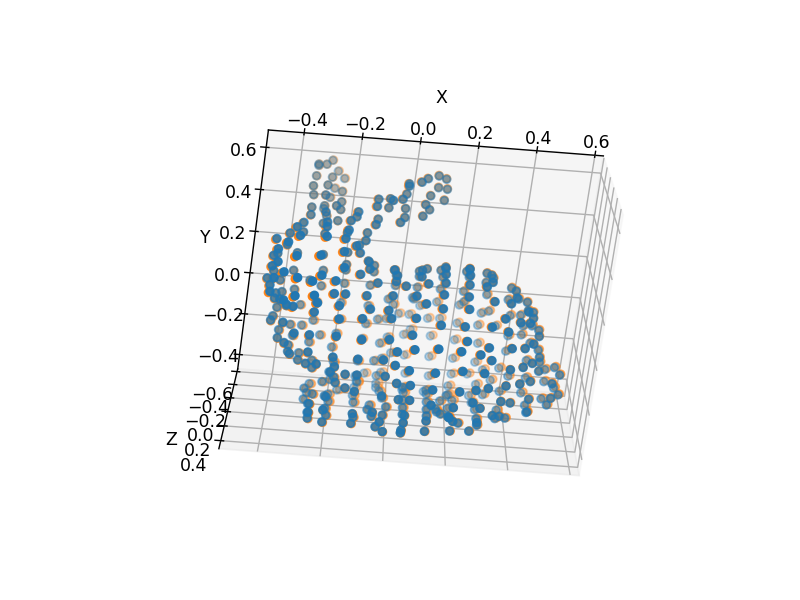

Text(0.5, 0, 'Z')

In [24]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bunny[:,0],bunny[:,1],bunny[:,2])
ax.scatter(bunny2T[:,0],bunny2T[:,1],bunny2T[:,2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')